In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

from methods.option import Option, Put, Call
from methods.node import Node
from methods.montecarlo import run, multirun, MonteCarlo

import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

# Monte Carlo Simulation for European Style Derivatives

In this notebook, I will demonstrate the functionality of the `MonteCarlo`class defined in `methods.montecarlo`. I will do this by introducing the `run` and `multirun` classes defined in the same file; I will then use the constructed numerical procedure to price a European call and put, and check this against the theoretical price derived from the Black-Scholes pricing formulas. The exercise taken will be exercise 10.6 in:

**Hull, J. C. (2003).** *Options, Futures, and Other Derivatives* (2nd ed.). Prentice-Hall. Chapter 10: The Black-Scholes Analysis.

### Contents
1. [Run and Multirun](#run-and-multirun)
2. [Monte Carlo Simulation](#monte-carlo-simulation)
3. [Other Applications and Further Work](#other-applications-and-further-work)
---

## Run and Multirun

The `run` and `multirun` classes can be used to simulate paths for a single variable or multiple variables respectively, each following a geometric brownian motion. We use geometric brownian motion because the proportional changes affecting the stock and other variables are assumed independent from the stock's price. The code can be customised to use any assumed distribution.

A variable $X$ following a geometric Brownian motion with drift rate $\mu$ and variance rate $\sigma$ has the following property:
$$ dX = \mu X dt + \sigma X dz \: \text{ or } \:$$
$$dX/X = \mu dt + \sigma dz$$ 
where $z$ is a Wiener process, meaning $\Delta z = \epsilon \sqrt{\Delta t}$ with $\epsilon \sim N(0,1)$ is standard gaussian.


Using Ito's lemma we can observe the process $G = ln(X)$:
$$ dG = (\mu - \frac{\sigma^2}{2})dt + \sigma dz$$
which, using the fact that dz is a Wiener process, gives:
$$\Delta G = ln(X_{t_1}) - ln(X_{t_0}) \sim N((\mu - \frac{\sigma^2}{2})\Delta t,\: \sigma^2\Delta t)$$

This gives:
$$ln(X_{t_1}) - ln(X_{t_0}) = (\mu - \frac{\sigma^2}{2})\Delta t + \epsilon \sigma \sqrt{\Delta t}$$
and with some manipulation:
$$\Delta X = X(e^{((\mu - \frac{\sigma^2}{2})\Delta t + \epsilon \sigma \sqrt{\Delta t})} - 1)$$

This relationship is what is used to simulate runs. To simulate multiple variables we assume each variable follows a different Wiener process and we give our `MonteCarlo` object the covariance matrix (or equivalent information) relating these.

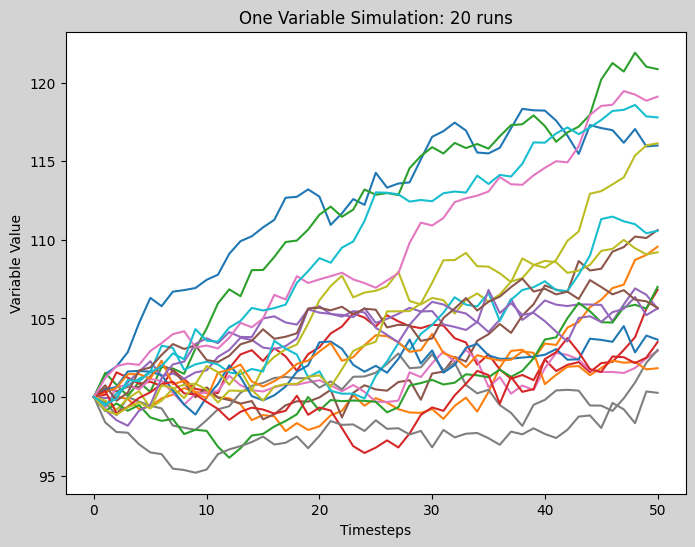

In [2]:
# Time in years.
time = 1
# Steps in simulation (single run).
tsteps = 50
# Starting value, drift and variance rate of underlying variable.
starting = 100
drift = 0.1
vol = 0.05

single = run(time, tsteps, starting, drift, vol)
n = 20
plt.figure(figsize=(8,6), facecolor='lightgray')
plt.title(f'One Variable Simulation: {n} runs')
for _ in range(n):
    single.simulate()  
    plt.plot(single.values)
plt.xlabel('Timesteps')
plt.ylabel('Variable Value')
plt.show()

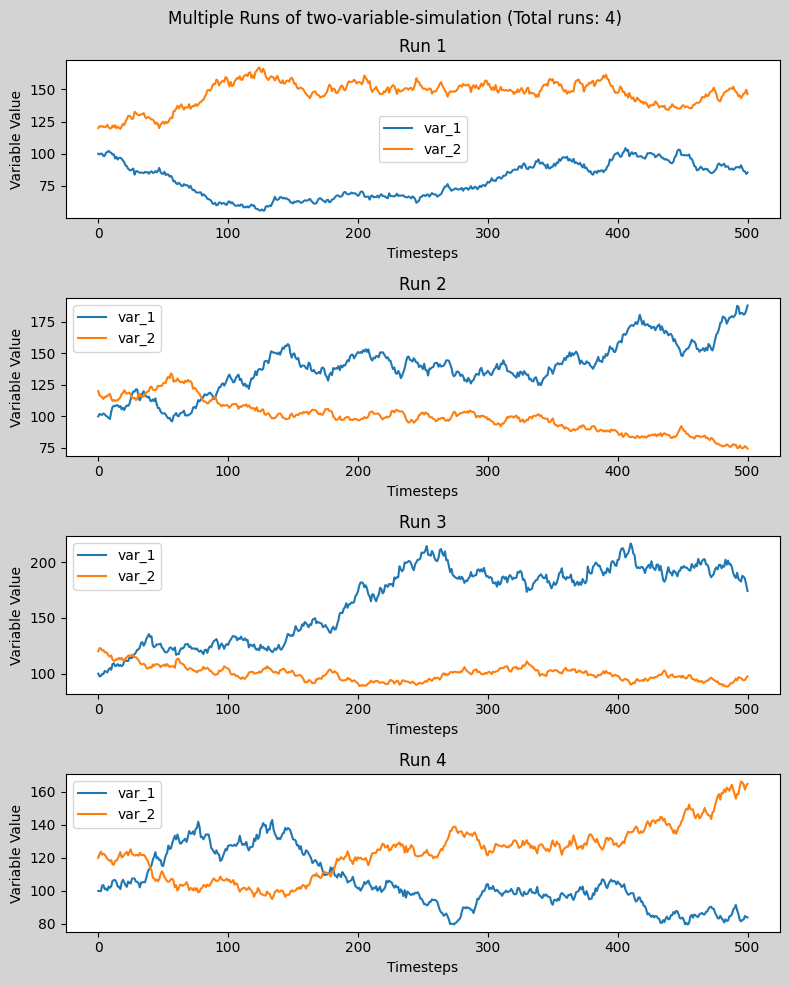

In [3]:
# Time in years.
time = 1
# Steps in simulation (single run).
tsteps = 500
# Starting value, drift and covariance information of underlying variables.
starting = np.array([100, 120])
drift = np.array([0.1, 0.1])
vol = np.array([0.4, 0.3])
# In this example there is strong negative correlation.
corr = np.array([[1, -0.7],[-0.7, 1]])

multi = multirun(time, tsteps, starting, drift, vol=vol, corr=corr)

plt.figure(figsize=(8,10), facecolor='lightgray')
n_plots = 4
plt.suptitle(f'Multiple Runs of two-variable-simulation (Total runs: {n_plots})')
for i in range(n_plots):
    multi.simulate()
    plt.subplot(n_plots, 1, i+1)
    plt.plot(multi.values[:,0], label='var_1')
    plt.plot(multi.values[:,1], label='var_2')
    plt.title(f'Run {i+1}')
    plt.xlabel('Timesteps')
    plt.ylabel('Variable Value')
    plt.legend()
plt.tight_layout()
plt.show()

---

## Monte Carlo Simulation

## Example 10.6: Pricing European Call and Put Options

In [4]:
# Time to maturity in years
time = 0.5
# Number of time steps and runs.
tsteps = 1000
nruns = 15000

# Starting value of underlying.
starting = np.array([42])
# Interest Rate.
r = 0.1
# In a risk neutral setting the expected growth rate of the value of a security is equal to r,
# where r is the interest rate and q is the continuous dividend yield paid by the stock.
drift = np.array([r])
# Stock price volatility.
vol = np.array([0.2])

# Defining strike price and payoff functions; We do not use the Option class to 
# define payoffs more freely without restrictions posed by available Node attributes.
X = 40
call_payoff = lambda S: max(S-X, 0)
put_payoff = lambda S: max(X-S, 0)

mc = MonteCarlo(time, tsteps, starting, drift, vol=vol, var_names=['S'], r=r, nruns=nruns)

mc.run()
# The simulated runs can then be used to price multiple derivatives.

In [5]:
print(f"The computed price of the European Call Option is {mc.price(payoff_func=call_payoff, variables=['S'])}")
print(f"The computed price of the European Put Option is {mc.price(payoff_func=put_payoff, variables=['S'])}")

The computed price of the European Call Option is 4.781787523112943
The computed price of the European Put Option is 0.7993312079906679


**How good is numerical estimation?** These values are close to the theoretical values 4.76 and 0.81 for the call and put respectively.


---

## Other Applications and Further Work


The above derivative is very simple and only depends on one variable. We can use other variables, including the interest rate (to do this call the process `'r'` when giving the object its `var_names`: the payoffs for each run are then discounted using the mean interest rate throughout the run).

**Note**: In a risk neautral world stock prices grow at continuous rate (risk-free interest rate - continuous dividend yield) and other variables the proportional drift rate must be reduced by $\lambda \sigma$ where $\sigma$ is the variable volatility and $\lambda$ is its market price of risk.

**Further work**: allow volatility to also be a stochastic process and allow for non-constant drift rates for each variable. For this the drift and covariance parameters would have to be updated every step of the run: I would go about doing this by calculating these at each step and then calculating the stochastic steps for the other variables.